### Monte Carlo Simulation of Profitability Likelihood

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
df_inputs = pd.read_csv('inputprice.csv')

df_inputs['HDPE/brick'] = df_inputs['HDPE price per kg'] * 0.1111
df_inputs['Sand/brick'] = df_inputs['Sand price per kg'] * 0.4444
hdpe_mean = df_inputs['HDPE/brick'].mean()
sand_mean = df_inputs['Sand/brick'].mean()

df_inputs.head(5)

,HDPE price per kg,Sand price per kg,HDPE/brick,Sand/brick
0,58,1.98,6.4438,0.879912
1,60,2.15,6.6660,0.955460
2,118,0.95,13.1098,0.422180
3,74,3.48,8.2214,1.546512
4,65,1.67,7.2215,0.742148


In [45]:
df_hdpe_variance = pd.read_csv('Linear Low Density Polyethylene Futures Historical Data.csv')
hdpe_variance = np.log(1+df_hdpe_variance['Price'].pct_change())
hdpe_variance

0           NaN
1      0.054431
2     -0.039547
3      0.035339
4     -0.049702
         ...   
540    0.001030
541    0.004624
542   -0.022286
543   -0.032493
544    0.000000
Name: Price, Length: 545, dtype: float64

In [47]:
mu_hdpe, sigma_hdpe = hdpe_variance.mean(), hdpe_variance.std()

$$ Profit_t  = n_t(P-V_t) - F $$
$$ V_t = X + m1_t + m2_t $$\
n = Units sold\
P = Price per unit\
V = Variable cost per unit\
F = Fixed cost\
m1 = Material cost per unit: HDPE\
m2
= Material cost per unit: Sand\
X = Other variable cost per unit

In [65]:
benchmark =  30000
weeks = 260

#inputs for fixed variables

F = 100000
X = 0.5
# Price to be determined

In [95]:
#inputs for moving variables and variance
m1 = hdpe_mean
m2, mu_m2, sigma_m2 = sand_mean, 0.0001, 0.02
n, mu_n, sigma_n = 100000, 0.0001, 0.02

In [173]:
num_simulations = 10000

##### Profit Function

In [147]:
def profit(P):
    m1_sim = (1 + np.random.normal(mu_hdpe, sigma_hdpe, weeks)).cumprod()
    m2_sim = (1 + np.random.normal(mu_m2, sigma_m2, weeks)).cumprod()
    n_sim = (1 + np.random.normal(mu_n, sigma_n, weeks)).cumprod()

    V = X + (m1*m1_sim) + (m2*m2_sim)
    y = ((n*n_sim)*(P-V))-F
    
    return y

##### Bayesian Optimisation for Unit Pricing

In [171]:
def price_eval(P):
    end_profit = []
    for i in range(num_simulations):
        y = profit(P)
        end_profit.append(y[-1])
        
    x = median(end_profit) - benchmark
    if x<0: x = 999999
    return -x

In [174]:
#!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

price_bo = BayesianOptimization(price_eval, {'P' : (5, 15)})
                              
# init_points=20, n_iter=100 for final pred
price_bo.maximize(init_points=20, n_iter=100, acq='ei')

|   iter    |  target   |     P     |
-------------------------------------
|  1        | -1e+06    |  7.305    |
|  2        | -2.249e+0 |  12.34    |
|  3        | -4.146e+0 |  14.34    |
|  4        | -2.64e+05 |  12.85    |
|  5        | -2.212e+0 |  12.35    |
|  6        | -6.206e+0 |  10.47    |
|  7        | -4.217e+0 |  14.44    |
|  8        | -1e+06    |  5.984    |
|  9        | -1.531e+0 |  11.54    |
|  10       | -3.852e+0 |  14.15    |
|  11       | -1.372e+0 |  11.44    |
|  12       | -1e+06    |  6.019    |
|  13       | -1e+06    |  7.649    |
|  14       | -1e+06    |  8.433    |
|  15       | -4.42e+05 |  14.79    |
|  16       | -1.998e+0 |  12.07    |
|  17       | -1e+06    |  9.392    |
|  18       | -1e+06    |  7.43     |
|  19       | -3.461e+0 |  13.81    |
|  20       | -4.167e+0 |  10.25    |
|  21       | -9.895e+0 |  10.96    |
|  22       | -3.981e+0 |  10.32    |
|  23       | -1e+06    |  5.0      |
|  24       | -3.54e+04 |  10.29    |
|  25       

In [175]:
print("Optimal Price: ", price_bo.max)

Optimal Price:  {'target': -880.0255699773188, 'params': {'P': 9.918219563043506}}


##### Monte Carlo Simulation with Graph

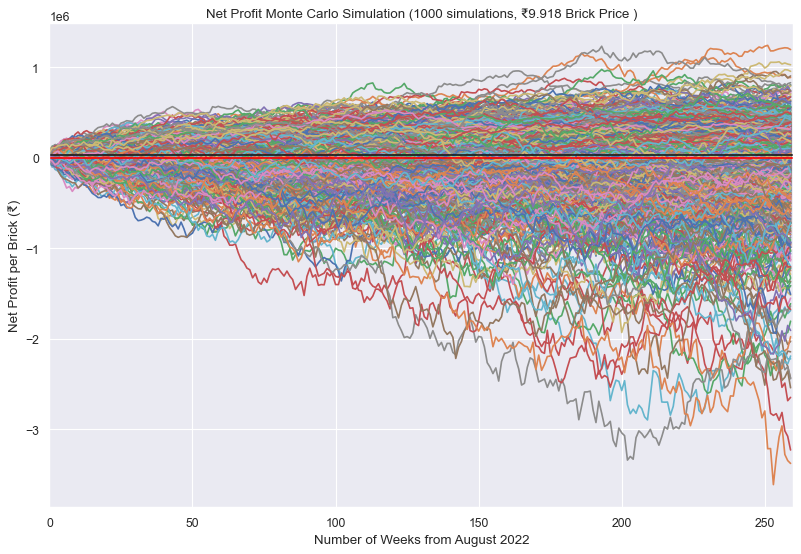

In [184]:
num_simulations = 1000
P = 9.918

yr1_profit = []
yr2_profit = []
yr3_profit = []
yr4_profit = []
yr5_profit = []

plt.figure(figsize=(12, 8), dpi=80)

for i in range(num_simulations):
    y = profit(P)
    
    yr1_profit.append(y[51])
    yr2_profit.append(y[103])
    yr3_profit.append(y[155])
    yr4_profit.append(y[207])
    yr5_profit.append(y[259])
    
    plt.title("Net Profit Monte Carlo Simulation (" + str(num_simulations) + " simulations, ₹" + str(P) +  " Brick Price )")
    plt.xlabel("Number of Weeks from August 2022")
    plt.ylabel("Net Profit per Brick (₹)")
    plt.xlim([0, 260])
    plt.plot(y)
    
plt.axhline(0, c='red')
plt.axhline(benchmark, c='k')

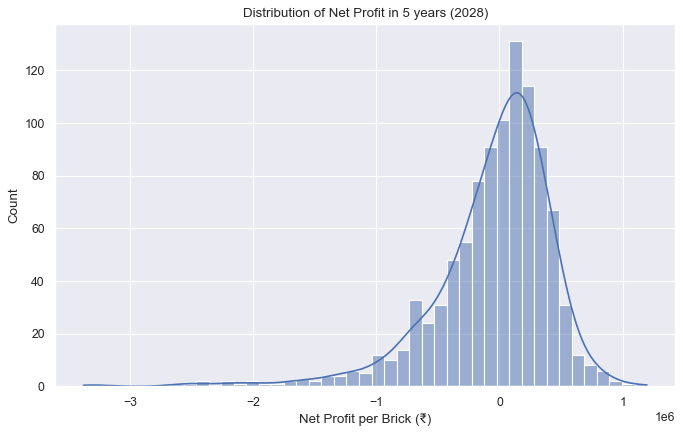

In [185]:
import seaborn as sns

plt.figure(figsize=(10, 6), dpi=80)
sns.set(style="darkgrid")
sns.histplot(yr5_profit, kde=True)
plt.title("Distribution of Net Profit in 5 years (2028)")
plt.xlabel("Net Profit per Brick (₹)")
plt.show()

##### Probabilities

In [186]:
from statistics import median
prob1 = (sum(x > 0 for x in yr1_profit)/len(yr1_profit))
prob2 = (sum(x > 0 for x in yr2_profit)/len(yr2_profit))
prob3 = (sum(x > 0 for x in yr3_profit)/len(yr3_profit))
prob4 = (sum(x > 0 for x in yr4_profit)/len(yr4_profit))
prob5 = (sum(x > 0 for x in yr5_profit)/len(yr5_profit))

In [187]:
print("The probability of profit is:")
print("Year 1: " + str(prob1*100) + "%")
print("Year 2: " + str(prob2*100) + "%")
print("Year 3: " + str(prob3*100) + "%")
print("Year 4: " + str(prob4*100) + "%")
print("Year 5: " + str(prob5*100) + "%")
print("Probability of staying profitable all 5 yrs: " + str(prob1*prob2*prob3*prob4*prob5*100)  + "%")

The probability of profit is:
Year 1: 53.1%
Year 2: 51.4%
Year 3: 52.900000000000006%
Year 4: 52.800000000000004%
Year 5: 54.50000000000001%
Probability of staying profitable all 5 yrs: 4.154738906736001%


In [188]:
prob1a = (sum(x > benchmark for x in yr1_profit)/len(yr1_profit))
prob2a = (sum(x > benchmark for x in yr2_profit)/len(yr2_profit))
prob3a = (sum(x > benchmark for x in yr3_profit)/len(yr3_profit))
prob4a = (sum(x > benchmark for x in yr4_profit)/len(yr4_profit))
prob5a = (sum(x > benchmark for x in yr5_profit)/len(yr5_profit))

In [189]:
print("The probability of profit above 3% benchmark is:")
print("Year 1: " + str(prob1a*100) + "%")
print("Year 2: " + str(prob2a*100) + "%")
print("Year 3: " + str(prob3a*100) + "%")
print("Year 4: " + str(prob4a*100) + "%")
print("Year 5: " + str(prob5a*100) + "%")
print("Probability of staying profitable above 3% benchmark all 5 yrs: " + str(prob1a*prob2a*prob3a*prob4a*prob5a*100)  + "%")

The probability of profit above 3% benchmark is:
Year 1: 46.300000000000004%
Year 2: 47.0%
Year 3: 48.6%
Year 4: 49.5%
Year 5: 51.4%
Probability of staying profitable above 3% benchmark all 5 yrs: 2.69081249778%


In [190]:
print("Most likely profit in:")
print("Year 1: $" + str(median(yr1_profit)))
print("Year 2: $" + str(median(yr2_profit)))
print("Year 3: $" + str(median(yr3_profit)))
print("Year 4: $" + str(median(yr4_profit)))
print("Year 5: $" + str(median(yr5_profit)))

Most likely profit in:
Year 1: $12489.228068498
Year 2: $8860.156519296514
Year 3: $18118.25722830797
Year 4: $24569.24942782599
Year 5: $38218.61703458967
